In [7]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [82]:
df = pd.read_csv('sea_avg_multi.csv')
df.head()

df = df.sample(frac=1, random_state=20).reset_index(drop=True) #shuffle dataframe
df.head()

#Splitting in train and test
split = math.floor(df.shape[0]*0.2) #80-20% split
test = df.head(n=split)
train = df.drop(index=df.index[:split]).reset_index(drop=True)
print(train.shape)
print(test.shape)

(36, 4)
(9, 4)


In [83]:
#Splitting X and Y
y_train = train['Extent'].to_numpy()
y_train = np.reshape(y_train, ((y_train.shape[0], 1)))

y_test = test['Extent'].to_numpy()
y_test = np.reshape(y_test, ((y_test.shape[0], 1)))

X_train = train.drop(['Extent'],axis=1)
X_train = X_train.to_numpy()

X_test = test.drop(['Extent'],axis=1)
X_test = X_test.to_numpy()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#Z normalisation
mu = np.mean(X_train,axis=0)
sigma = np.std(X_train,axis=0)
print(mu.shape, sigma.shape)

X_train = (X_train-mu)/sigma
print(type(X_train))

(36, 3) (9, 3) (36, 1) (9, 1)
(3,) (3,)
<class 'numpy.ndarray'>


In [84]:
class NeuralNetwork:
    def __init__(self,input_size,l,output_size, activationfunction="tanh"):
        np.random.seed(0)
        model = {}
        #for hidden layer
        model['W1']  = np.random.randn(input_size,l[0])
        model['b1'] = np.random.randn(1,l[0])
        
        #for output layer
        model['W2']  = np.random.randn(l[0],output_size)
        model['b2'] = np.random.randn(1,output_size)
        
        self.model = model
        self.activationfunction = activationfunction

    def linear(self, a):
      return a

    def relu(self, a):
      return(np.maximum(0, a))

    def reluderivative(self, a) :
      temp=a.copy()
      for i in range(a.shape[0]):
        for j in range(a.shape[1]):
          if(temp[i][j]>0):
            temp[i][j] = 1
          else:
            temp[i][j] = 0
      return temp
            
    def forward(self,x):
        W1,W2 = self.model['W1'],self.model['W2']
        b1,b2 = self.model['b1'],self.model['b2']
        
        #hidden layer
        z1 = np.dot(x,W1) + b1
        if(self.activationfunction=="relu"):
          a1 = self.relu(z1)
        if(self.activationfunction=="tanh"):
          a1 = np.tanh(z1)

        #output layer
        z2 = np.dot(a1,W2) + b2
        y_ = self.linear(z2)
        
        # Store the layer wise output for backprop later
        self.activations = (a1,y_)
        self.z = (z1, z2)
        return y_
    
    def backward(self,x,y,learning_rate=0.01):
        W1,W2 = self.model['W1'],self.model['W2']
        b1,b2 = self.model['b1'],self.model['b2']
        a1,y_ = self.activations
        z1, z2 = self.z

        # Output layer
        d2 = (y_ - y)
        dw2 = np.dot(a1.T,d2)
        db2 = np.sum(d2,axis=0)
        
        # Hidden layer
        d1 = np.dot(d2,W2.T)
        if(self.activationfunction=="relu"):
          d1 = d1*(self.reluderivative(z1))
        if(self.activationfunction=="tanh"):
          d1 = d1 * (1-np.square(a1))
        dw1 = np.dot(x.T,d1)
        db1 = np.sum(d1,axis=0)
        
        # Gradient Descent 
        self.model['W1'] -= learning_rate*dw1
        self.model['W2'] -= learning_rate*dw2
        self.model['b1'] -= learning_rate*db1
        self.model['b2'] -= learning_rate*db2
    
    def predict(self,x):
        out = self.forward(x)
        return out

    def loss(self, y,y_):
      l = (1/2)*np.mean((y_-y)**2)
      return l

    def r2Score(self,y, y_):
      num = np.sum((y-y_)**2)
      denom = np.sum((y-y.mean())**2)
      score = (1-num/denom)
      return score*100

    def fit(self, X ,Y,epochs, learning_rate):
    
      train_loss = []
      
      for i in range(epochs):
          Y_ = self.forward(X)
          l = self.loss(Y,Y_)
          train_loss.append(l)
          model.backward(X,Y, learning_rate)
          if ((i+1)%2500==0):
              r2score = self.r2Score(Y,Y_)
              print("Epoch %d Loss %.2f R2_score %.2f"%(i+1,l,r2score))
      return train_loss

In [85]:
# Model Details
input_size = 3
layers = [2] #Hidden Layers
output_size = 1
model = NeuralNetwork(input_size,layers,output_size, activationfunction="relu")
error_list = model.fit(X_train, y_train, epochs=25000, learning_rate=0.003)

#0.003 - relu
#0.02 - tanh

Epoch 2500 Loss 0.02 R2_score 90.15
Epoch 5000 Loss 0.02 R2_score 90.38
Epoch 7500 Loss 0.02 R2_score 90.68
Epoch 10000 Loss 0.02 R2_score 90.92
Epoch 12500 Loss 0.02 R2_score 91.05
Epoch 15000 Loss 0.02 R2_score 90.99
Epoch 17500 Loss 0.02 R2_score 91.09
Epoch 20000 Loss 0.02 R2_score 91.08
Epoch 22500 Loss 0.02 R2_score 91.82
Epoch 25000 Loss 0.02 R2_score 91.85


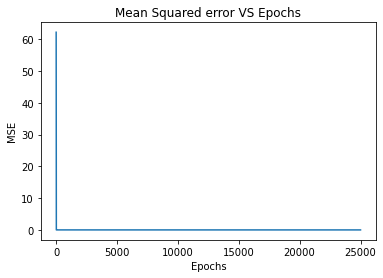

In [89]:
plt.plot(error_list)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Mean Squared error VS Epochs')
plt.show()

In [87]:
X_test = (X_test-mu)/sigma
y_hat = model.predict(X_test)
print("MSE on test set is: ",model.loss(y_test,y_hat))
print("R^2 score on test is: ",model.r2Score(y_test,y_hat))

MSE on test set is:  0.019691822331523764
R^2 score on test is:  94.38442555372927
